In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H1\labels_count\X_H1_full__on_HDRS21_Change_CenteredByStite.csv")

In [3]:
df['subject'] = df["Id"].str[0:5]
df['HDRS21_improvement_CenteredByStite'] = df['HDRS21_Change_CenteredByStite']*(-1)
median_value = df['HDRS21_improvement_CenteredByStite'].median()


# Step 2: Create a new label column
df['above_median_HDRS21_improvement_CenteredByStite'] =  df['HDRS21_improvement_CenteredByStite'].apply(lambda x: 1.0 if x > median_value else 0.0)

In [5]:
def filter_by_percentile(df, column):
    column_data = df[column]
    threshold_high = column_data.quantile(0.68)
    threshold_low = column_data.quantile(0.32)
    filtered_df = df[(column_data > threshold_high) | (column_data < threshold_low)]
    return filtered_df

def train_svc(X_train, y_train, X_test, params):
    model = SVC(**params, probability=True)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    return y_pred_prob

In [6]:

models = ['SVC' + str(i+1) for i in range(20)]
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV']
predictions = {}


# Define the hyperparameters for different SVC models
svc_params =  [
    {'C': 0.01, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.025, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.05, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.06, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.07, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.08, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.09, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.1, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.11, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.12, 'kernel': 'poly', 'degree' : 3},
    {'C': 0.01, 'kernel': 'poly'},
    {'C': 0.025, 'kernel': 'poly'},
    {'C': 0.05, 'kernel': 'poly'},
    {'C': 0.06, 'kernel': 'poly'},
    {'C': 0.07, 'kernel': 'poly'},
    {'C': 0.08, 'kernel': 'poly'},
    {'C': 0.09, 'kernel': 'poly'},
    {'C': 0.1, 'kernel': 'poly'},
    {'C': 0.11, 'kernel': 'poly'},
    {'C': 0.12, 'kernel': 'poly'}
]

for i, model_name in enumerate(models):
    predictions[model_name] = {}

    for j in range(len(df)):
        row = df.iloc[[j]]
        row_index = row.index.values[0]
        train_df = df.drop(j)  # Remove current row from the training data
        test_df = row
        train_df = filter_by_percentile(train_df, 'HDRS21_improvement_CenteredByStite')
        X_train = train_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])
        X_test = test_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])
        y_train = train_df["above_median_HDRS21_improvement_CenteredByStite"]
        y_test = test_df["above_median_HDRS21_improvement_CenteredByStite"]

        scaler = StandardScaler()
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        # Train and predict using the specified SVC model
        y_pred_prob = train_svc(scaled_X_train, y_train, scaled_X_test, svc_params[i])

        predictions[model_name][row_index] = y_pred_prob

    print('finished')

# Create a list to store AUC scores for each model
auc_scores = []

# Assuming 'y_true' is the true labels from the DataFrame
y_true = df["above_median_HDRS21_improvement_CenteredByStite"]

# Calculate AUC scores for each model
auc_scores = {}
for i, model_name in enumerate(models):
    y_scores = [predictions[model_name][idx] for idx in df.index]
    auc_score = roc_auc_score(y_true, y_scores)
    auc_scores[model_name] = auc_score
    
    print(f'AUC for {model_name}: {auc_score:.4f}')
    
    
# Calculate metrics for each model based on all predictions
results = {}
for i, model_name in enumerate(models):
    model_predictions = predictions[model_name]
    all_y_true = df['above_median_HDRS21_improvement_CenteredByStite']
    all_y_pred = [np.round(model_predictions.get(row_index)) for row_index in df.index]

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(all_y_true, all_y_pred).ravel()

    # Calculate PPV (Positive Predictive Value) and NPV (Negative Predictive Value)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0

    # Calculate other metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    sensitivity = recall_score(all_y_true, all_y_pred)
    specificity = recall_score(all_y_true, all_y_pred, pos_label=0)
    F1_score = f1_score(all_y_true, all_y_pred)

    # Store hyperparameters in the result table
    params_str = ', '.join([f"{param}={val}" for param, val in svc_params[i].items()])
    results[model_name] = {
        'Hyperparameters': params_str,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV': ppv,
        'NPV': npv,
        'F1 Score': F1_score 
    }

# Create a DataFrame to display the results
combined_results = pd.DataFrame.from_dict(results, orient='index')




finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
AUC for SVC1: 0.7845
AUC for SVC2: 0.7613
AUC for SVC3: 0.8161
AUC for SVC4: 0.8238
AUC for SVC5: 0.7679
AUC for SVC6: 0.8583
AUC for SVC7: 0.7929
AUC for SVC8: 0.8417
AUC for SVC9: 0.7726
AUC for SVC10: 0.7786
AUC for SVC11: 0.8571
AUC for SVC12: 0.7500
AUC for SVC13: 0.8012
AUC for SVC14: 0.8095
AUC for SVC15: 0.7690
AUC for SVC16: 0.7940
AUC for SVC17: 0.8619
AUC for SVC18: 0.7810
AUC for SVC19: 0.7702
AUC for SVC20: 0.7893


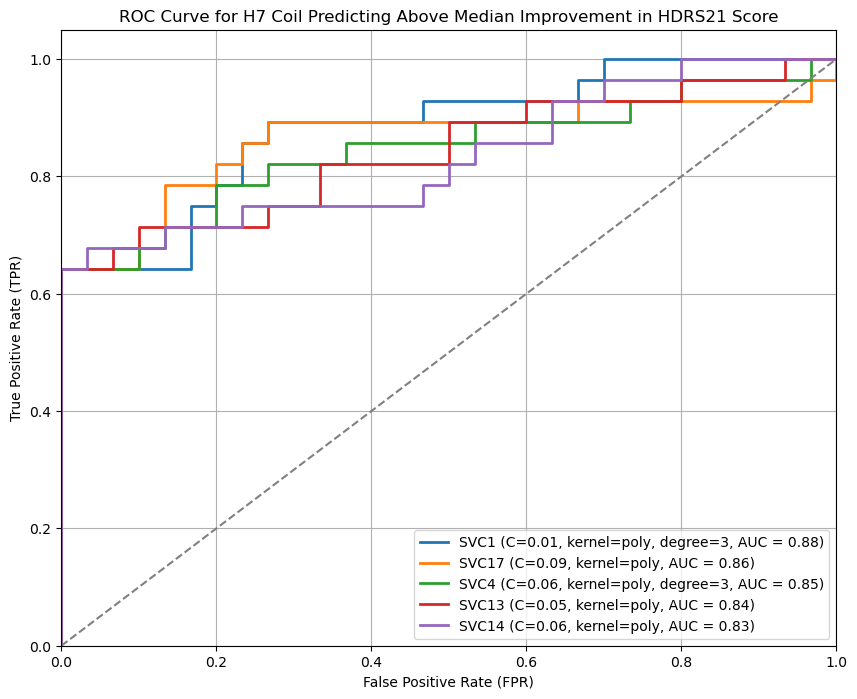

In [14]:
# Sort models based on AUC scores and get the top 5
top_models = sorted(auc_scores, key=auc_scores.get, reverse=True)[:5]

# Create a nice AUC plot using seaborn with legends for the top 5 models
plt.figure(figsize=(10, 8))
for model_name in top_models:
    # Get the hyperparameters from the svc_params dictionary
    model_params = svc_params[models.index(model_name)]
    hyperparams_str = ', '.join([f"{param}={val}" for param, val in model_params.items()])
    
    fpr, tpr, _ = roc_curve(y_true, [predictions[model_name][idx] for idx in df.index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ({hyperparams_str}, AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for H7 Coil Predicting Above Median Improvement in HDRS21 Score')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig(r"C:\Users\user\OneDrive - post.bgu.ac.il\final_project\final_report_results\H1_SVC_poly_ROC_2_better")
plt.show()




In [16]:
combined_results.index.name = 'Model'
combined_results#

,Hyperparameters,Accuracy,Sensitivity,Specificity,PPV,NPV,F1 Score
Model,,,,,,,
SVC1,"C=0.01, kernel=poly, degree=3",0.810345,0.892857,0.733333,0.757576,0.880000,0.819672
SVC2,"C=0.025, kernel=poly, degree=3",0.810345,0.678571,0.933333,0.904762,0.756757,0.775510
SVC3,"C=0.05, kernel=poly, degree=3",0.793103,0.642857,0.933333,0.900000,0.736842,0.750000
SVC4,"C=0.06, kernel=poly, degree=3",0.827586,0.642857,1.000000,1.000000,0.750000,0.782609
SVC5,"C=0.07, kernel=poly, degree=3",0.827586,0.642857,1.000000,1.000000,0.750000,0.782609
SVC6,"C=0.08, kernel=poly, degree=3",0.827586,0.642857,1.000000,1.000000,0.750000,0.782609
SVC7,"C=0.09, kernel=poly, degree=3",0.827586,0.642857,1.000000,1.000000,0.750000,0.782609
SVC8,"C=0.1, kernel=poly, degree=3",0.827586,0.642857,1.000000,1.000000,0.750000,0.782609
SVC9,"C=0.11, kernel=poly, degree=3",0.827586,0.642857,1.000000,1.000000,0.750000,0.782609


In [26]:
combined_results.to_csv(r"C:\final_project\freqs_power_model\result_tables\H1_full_6832_SVC_poly_2_better.csv")

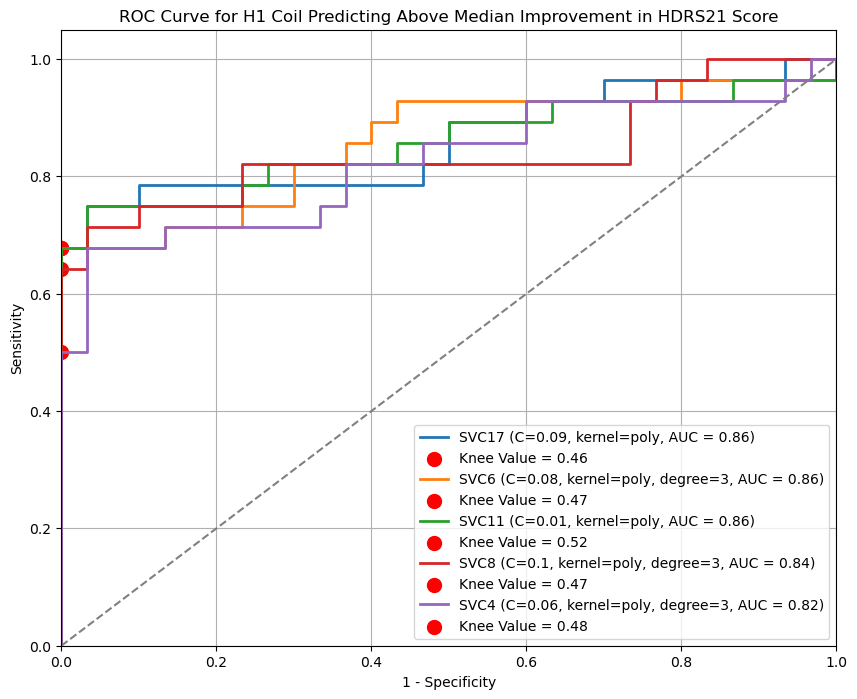

In [7]:

auc_scores = {}
knee_values = {}
for i, model_name in enumerate(models):
    y_scores = [predictions[model_name][idx] for idx in df.index]
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    auc_scores[model_name] = roc_auc

    # Calculate Youden's J statistic for each point on the ROC curve
    youdens_j = tpr + (1 - fpr) - 1

    # Find the index of the point with the maximum Youden's J value
    knee_index = np.argmax(youdens_j)

    # Store the knee value corresponding to the optimal threshold
    knee_values[model_name] = {
        'Threshold': _[knee_index],
        'Sensitivity': tpr[knee_index],
        'Specificity': 1 - fpr[knee_index],
        'Youden\'s J': youdens_j[knee_index]
    }

# Sort models based on AUC scores and get the top 5
top_models = sorted(auc_scores, key=auc_scores.get, reverse=True)[:5]

# Create a nice AUC plot using seaborn with legends for the top 5 models
plt.figure(figsize=(10, 8))
for model_name in top_models:
    # Get the hyperparameters from the svc_params dictionary
    model_params = svc_params[models.index(model_name)]
    hyperparams_str = ', '.join([f"{param}={val}" for param, val in model_params.items()])
    
    fpr, tpr, _ = roc_curve(y_true, [predictions[model_name][idx] for idx in df.index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ({hyperparams_str}, AUC = {roc_auc:.2f})')

    # Plot the knee value on the curve
    knee_value = knee_values[model_name]['Threshold']
    plt.scatter(fpr[knee_index], tpr[knee_index], marker='o', color='red', s=100, label=f'Knee Value = {knee_value:.2f}')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve for H1 Coil Predicting Above Median Improvement in HDRS21 Score')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(r"C:\Users\user\OneDrive - post.bgu.ac.il\final_project\final_report_results\H1_SVC_poly_ROC_3_better")
plt.show()
